In [1]:
import numpy as np
import tensorflow.keras.backend as K
import numpy as np
import tensorflow as tf

from tensorflow import keras
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input, Conv1D, MaxPooling1D, BatchNormalization, Flatten, Dense, Average, Dropout, SpatialDropout1D
from keras.utils import plot_model

In [2]:
dataset = np.load("../../KEMDy20_v1_1/Extract/Dataset_MFCC.npz", allow_pickle=True)

In [3]:
train_x = dataset["train_x"]
train_y = dataset["train_y"]
test_x = dataset["test_x"]
test_y = dataset["test_y"]

In [4]:
def Macro_f1(y_true, y_pred):
    y_true = K.round(y_true)
    y_pred = K.round(y_pred)
    
    tp = K.sum(y_true * y_pred, axis=0)
    fp = K.sum((1-y_true) * y_pred, axis=0)
    fn = K.sum(y_true * (1-y_pred), axis=0)
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    f1 = 2 * precision * recall / (precision + recall + K.epsilon())
    
    # Calculate macro F1 score
    macro_f1 = K.mean(f1)
    
    return macro_f1

In [5]:
# 레이블 인코딩
le = LabelEncoder()
le.fit(train_y)
encoded_train_y = le.transform(train_y)

# 원핫 인코딩
onehot_train_y = to_categorical(encoded_train_y)

# train_y에서 사용된 LabelEncoder 객체를 그대로 사용하여 test_y 인코딩
encoded_test_y = le.transform(test_y)

# test_y를 원핫 인코딩
onehot_test_y = to_categorical(encoded_test_y)

In [6]:
model_count = 2

# Split the train and test data into four parts
train_data_parts = np.split(train_x, model_count, axis=1)
test_data_parts = np.split(test_x, model_count, axis=1)

In [7]:
# Define submodel architecture
def create_submodel(input_shape):
    submodel_input = Input(shape=input_shape)
    x = Conv1D(filters=16, kernel_size=3, activation='relu')(submodel_input)
    x = MaxPooling1D(pool_size=2)(x)
    x = BatchNormalization()(x)
    x = Conv1D(filters=32, kernel_size=3, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = BatchNormalization()(x)
    x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(rate=0.2)(x)
    x = Flatten()(x)
    x = Dense(units=256, activation='relu')(x)
    x = Dropout(rate=0.2)(x)
    x = Dense(units=7, activation='softmax')(x)
    return submodel_input, x

# Define the list to store submodels and input shapes
submodels = []
input_shapes = []

# Create submodels
for i in range(model_count):
    input_shape = train_data_parts[i].shape[1:]
    submodel_input, submodel_output = create_submodel(input_shape)
    submodels.append(Model(inputs=submodel_input, outputs=submodel_output))
    input_shapes.append(input_shape)

# Define final model architecture
inputs = [Input(shape=input_shape) for input_shape in input_shapes]
outputs = [[submodel(inputs[i])] for i, submodel in enumerate(submodels)]
merged = Average()([output[0] for output in outputs])

#merged = Dense(units=7, activation='softmax')(Flatten()(merged))
final_model = Model(inputs=inputs, outputs=merged)

# Compile the final model
final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[Macro_f1])

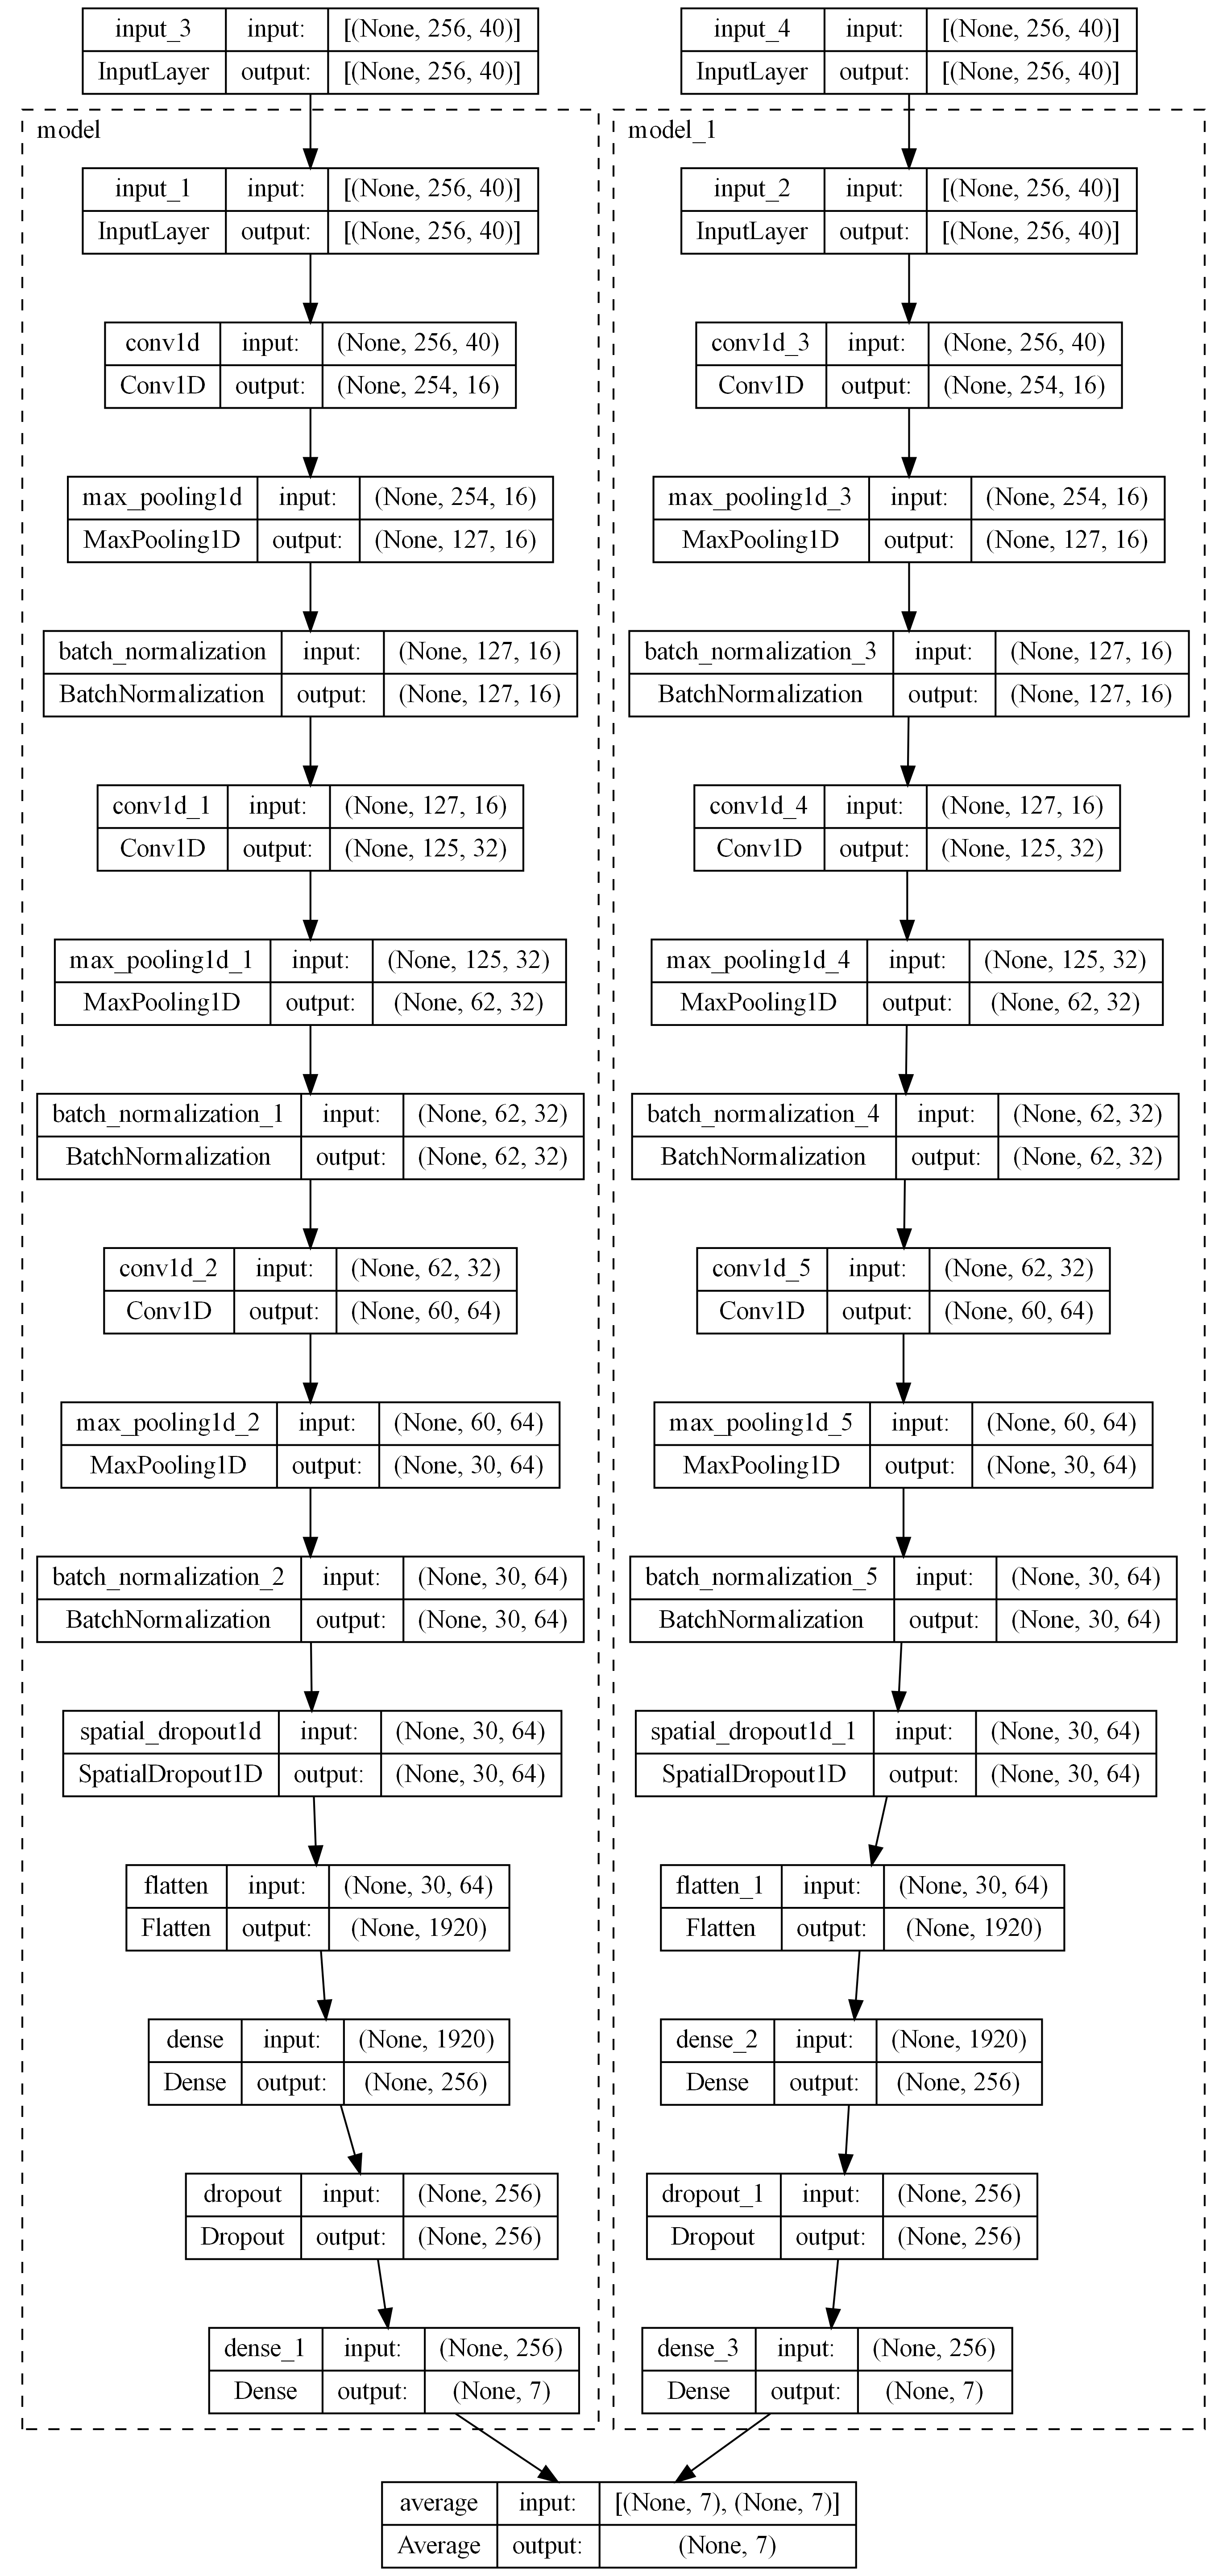

In [8]:
# Visualize final model architecture
plot_model(final_model, to_file='../final_model.png', show_shapes=True, expand_nested=True, dpi=300)

In [ ]:
import os
from tensorflow.keras import callbacks

# Prepare the data for training
final_train_data = [train_data_parts[i].reshape(train_x.shape[0], -1, train_x.shape[2]) for i in range(model_count)]
final_test_data = [test_data_parts[i].reshape(test_x.shape[0], -1, test_x.shape[2]) for i in range(model_count)]

save_model_path="../Model/"
weight_path=save_model_path+"Model_weights_best_count"+str(model_count)+".hdf5"

if not os.path.exists(save_model_path):
    os.mkdir(save_model_path)

checkpoint = callbacks.ModelCheckpoint(
    weight_path,
    monitor='val_Macro_f1',
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
    mode='max'
)

# Train the final model
final_model.fit(
    final_train_data,
    onehot_train_y,
    epochs=100,
    batch_size=32,
    validation_data=(final_test_data, onehot_test_y),
    callbacks=[checkpoint]
)

# Evaluate the final model on the test data
test_loss, test_macro_f1 = final_model.evaluate(final_test_data, onehot_test_y)
print(f'Test loss: {test_loss}, test macro_f1: {test_macro_f1}')

Epoch 1/100
809/810 [============================>.] - ETA: 0s - loss: 1.5175 - Macro_f1: 0.1519
Epoch 1: val_Macro_f1 improved from -inf to 0.07605, saving model to ../Model\Model_weights_best_count2.hdf5
810/810 [==============================] - 23s 21ms/step - loss: 1.5174 - Macro_f1: 0.1518 - val_loss: 1.4215 - val_Macro_f1: 0.0760
Epoch 2/100
808/810 [============================>.] - ETA: 0s - loss: 1.3444 - Macro_f1: 0.1438
Epoch 2: val_Macro_f1 did not improve from 0.07605
810/810 [==============================] - 16s 19ms/step - loss: 1.3448 - Macro_f1: 0.1437 - val_loss: 1.3974 - val_Macro_f1: 0.0671
Epoch 3/100
808/810 [============================>.] - ETA: 0s - loss: 1.2984 - Macro_f1: 0.1444
Epoch 3: val_Macro_f1 did not improve from 0.07605
810/810 [==============================] - 16s 20ms/step - loss: 1.2980 - Macro_f1: 0.1444 - val_loss: 1.3765 - val_Macro_f1: 0.0698
Epoch 4/100
809/810 [============================>.] - ETA: 0s - loss: 1.2468 - Macro_f1: 0.1564
Ep

809/810 [============================>.] - ETA: 0s - loss: 0.3630 - Macro_f1: 0.7200
Epoch 27: val_Macro_f1 did not improve from 0.17663
810/810 [==============================] - 16s 19ms/step - loss: 0.3630 - Macro_f1: 0.7193 - val_loss: 1.9842 - val_Macro_f1: 0.1720
Epoch 28/100
810/810 [==============================] - ETA: 0s - loss: 0.3510 - Macro_f1: 0.7264
Epoch 28: val_Macro_f1 did not improve from 0.17663
810/810 [==============================] - 16s 20ms/step - loss: 0.3510 - Macro_f1: 0.7264 - val_loss: 1.9455 - val_Macro_f1: 0.1694
Epoch 29/100
810/810 [==============================] - ETA: 0s - loss: 0.3427 - Macro_f1: 0.7369
Epoch 29: val_Macro_f1 did not improve from 0.17663
810/810 [==============================] - 15s 19ms/step - loss: 0.3427 - Macro_f1: 0.7369 - val_loss: 2.0045 - val_Macro_f1: 0.1736
Epoch 30/100
807/810 [============================>.] - ETA: 0s - loss: 0.3426 - Macro_f1: 0.7366
Epoch 30: val_Macro_f1 did not improve from 0.17663
810/810 [=====

810/810 [==============================] - 16s 20ms/step - loss: 0.2451 - Macro_f1: 0.8004 - val_loss: 2.5103 - val_Macro_f1: 0.1904
Epoch 56/100
808/810 [============================>.] - ETA: 0s - loss: 0.2382 - Macro_f1: 0.7986
Epoch 56: val_Macro_f1 did not improve from 0.19040
810/810 [==============================] - 16s 20ms/step - loss: 0.2384 - Macro_f1: 0.7977 - val_loss: 2.4613 - val_Macro_f1: 0.1825
Epoch 57/100
808/810 [============================>.] - ETA: 0s - loss: 0.2483 - Macro_f1: 0.7969
Epoch 57: val_Macro_f1 did not improve from 0.19040
810/810 [==============================] - 15s 19ms/step - loss: 0.2483 - Macro_f1: 0.7962 - val_loss: 2.3725 - val_Macro_f1: 0.1786
Epoch 58/100
808/810 [============================>.] - ETA: 0s - loss: 0.2570 - Macro_f1: 0.7913
Epoch 58: val_Macro_f1 did not improve from 0.19040
810/810 [==============================] - 15s 19ms/step - loss: 0.2571 - Macro_f1: 0.7905 - val_loss: 2.3616 - val_Macro_f1: 0.1858
Epoch 59/100
808/8

808/810 [============================>.] - ETA: 0s - loss: 0.1876 - Macro_f1: 0.8282
Epoch 84: val_Macro_f1 did not improve from 0.19215
810/810 [==============================] - 16s 19ms/step - loss: 0.1876 - Macro_f1: 0.8275 - val_loss: 2.7915 - val_Macro_f1: 0.1828
Epoch 85/100
810/810 [==============================] - ETA: 0s - loss: 0.1920 - Macro_f1: 0.8210
Epoch 85: val_Macro_f1 did not improve from 0.19215
810/810 [==============================] - 16s 20ms/step - loss: 0.1920 - Macro_f1: 0.8210 - val_loss: 2.6309 - val_Macro_f1: 0.1863
Epoch 86/100
809/810 [============================>.] - ETA: 0s - loss: 0.1831 - Macro_f1: 0.8266
Epoch 86: val_Macro_f1 did not improve from 0.19215
810/810 [==============================] - 16s 20ms/step - loss: 0.1831 - Macro_f1: 0.8259 - val_loss: 2.8167 - val_Macro_f1: 0.1912
Epoch 87/100
807/810 [============================>.] - ETA: 0s - loss: 0.1850 - Macro_f1: 0.8289
Epoch 87: val_Macro_f1 improved from 0.19215 to 0.19390, saving mo

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

final_model.load_weights(weight_path)
best_eva_list = final_model.evaluate(final_test_data, onehot_test_y)
loss = best_eva_list[0]
macro_f1 = best_eva_list[1]
print('Model evaluation: ', best_eva_list)
y_pred_best = final_model.predict(final_test_data)
em = classification_report(
    np.argmax(onehot_test_y,axis=1),
    np.argmax(y_pred_best,axis=1),
    target_names=le.classes_,
    output_dict=True
)
print(classification_report(np.argmax(onehot_test_y,axis=1), np.argmax(y_pred_best,axis=1), target_names=le.classes_))

198/198 [==============================] - 1s 5ms/step - loss: 2.6990 - Macro_f1: 0.1975
Model evaluation:  [2.6989755630493164, 0.19749735295772552]
198/198 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

       angry       0.25      0.25      0.25       664
     disqust       0.24      0.15      0.19       470
        fear       0.23      0.12      0.16       291
       happy       0.39      0.37      0.38      1128
     neutral       0.71      0.82      0.76      2741
         sad       0.26      0.27      0.26       629
    surprise       0.28      0.23      0.25       389

    accuracy                           0.50      6312
   macro avg       0.34      0.32      0.32      6312
weighted avg       0.48      0.50      0.49      6312



In [11]:
final_model.load_weights(weight_path)
best_eva_list = final_model.evaluate(final_train_data, onehot_train_y)
loss = best_eva_list[0]
macro_f1 = best_eva_list[1]
print('Model evaluation: ', best_eva_list)
y_pred_best = final_model.predict(final_train_data)
em = classification_report(
    np.argmax(onehot_train_y,axis=1),
    np.argmax(y_pred_best,axis=1),
    target_names=le.classes_,
    output_dict=True
)
print(classification_report(np.argmax(onehot_train_y,axis=1), np.argmax(y_pred_best,axis=1), target_names=le.classes_))

810/810 [==============================] - 4s 5ms/step - loss: 0.0031 - Macro_f1: 0.7198
Model evaluation:  [0.0031339016277343035, 0.7197607159614563]
810/810 [==============================] - 4s 5ms/step
              precision    recall  f1-score   support

       angry       1.00      1.00      1.00      2743
     disqust       1.00      1.00      1.00      1912
        fear       1.00      1.00      1.00      1138
       happy       1.00      1.00      1.00      4603
     neutral       1.00      1.00      1.00     11632
         sad       1.00      1.00      1.00      2340
    surprise       1.00      1.00      1.00      1522

    accuracy                           1.00     25890
   macro avg       1.00      1.00      1.00     25890
weighted avg       1.00      1.00      1.00     25890



In [7]:
#from sklearn.manifold import TSNE
#import matplotlib.pyplot as plt

#tsne = TSNE(n_components=2, random_state=0)
#digits_tsne = tsne.fit_transform(train_aug_x)

In [8]:
#plt.figure(figsize=(10, 8))
#plt.scatter(digits_tsne[:, 0], digits_tsne[:, 1])
#plt.colorbar()
#plt.show()